# Previsão do preço de ações

Autor do notebook: [Bruno Silva](https://github.com/bgsilva)

Notebook criado para ilustrar como podemos usar o Python e algumas de suas principais bibliotecas para criar modelos de previsão do preço de ações.

Como métricas de avaliação dos modelos, serão utilizadas: RMSE e MAE.

## Importando as bibliotecas

Abaixo importamos as bibliotecas que serão utizadas no código a seguir.

In [1]:
# importando as bibliotecas utilizadas
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.figure_factory as ff

# p/ ficar visível no github
import plotly.io as pio
# pio.renderers
pio.renderers.default = "svg" # ativar p/ github

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

from datetime import datetime
import yfinance as yf

Também foi criada uma função para a plotagem de gráficos que será utilizada mais a frente.

In [2]:
# Função criada para plotar gráficos interativos usando o Plotly Express
def interactive_plot(df, title, width=800, height=600):
    fig = px.line(title=title, width=width, height=height)
    for i in df.columns[1:]:
        fig.add_scatter(x=df['Date'], y=df[i], name=i)
    fig.show()

## Carregando os dados

A ação utilizada nos modelos criados será a ação `MGLU3`, mas poderia ser qualquer outra.

Para obter os dados, usaremos a biblioteca [yfinance](https://pypi.org/project/yfinance/).

O período analisado será de 4/1/2016 até 5/1/2022.

In [3]:
today = datetime.today().strftime('2022-01-06')
start_date = '2016-01-01'
mglu3_df = yf.download('MGLU3.SA', start_date, today)
mglu3_df

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2016-01-04,0.066210,0.071484,0.064921,0.070117,0.066922,138547200
2016-01-05,0.071523,0.072578,0.070117,0.070820,0.067593,96179200
2016-01-06,0.070820,0.071484,0.064687,0.064687,0.061740,117324800
2016-01-07,0.062500,0.062500,0.051171,0.056093,0.053537,226688000
2016-01-08,0.058593,0.059570,0.055664,0.056328,0.053762,97638400
...,...,...,...,...,...,...
2021-12-29,6.840000,6.900000,6.700000,6.760000,6.760000,79247400
2021-12-30,6.800000,7.410000,6.770000,7.220000,7.220000,180329400
2022-01-03,7.410000,7.410000,6.670000,6.720000,6.720000,145442000


Precisamos deixar 'Date' como coluna:

In [4]:
# ajustando 'Date' como coluna
mglu3_df = mglu3_df.reset_index() 

Aqui podemos observar algumas infomações básicas do dataset e suas features.

In [5]:
mglu3_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1495 entries, 0 to 1494
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       1495 non-null   datetime64[ns]
 1   Open       1495 non-null   float64       
 2   High       1495 non-null   float64       
 3   Low        1495 non-null   float64       
 4   Close      1495 non-null   float64       
 5   Adj Close  1495 non-null   float64       
 6   Volume     1495 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 81.9 KB


Abaixo temos um resumo estatístico das features numéricas.

In [6]:
mglu3_df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1495.000000,1495.000000,1495.000000,1495.000000,1495.000000,1.495000e+03
mean,8.245743,8.408608,8.065304,8.232777,8.142583,4.557305e+07
std,8.189070,8.336370,8.023556,8.176620,8.175388,3.129862e+07
min,0.049687,0.051484,0.049218,0.049453,0.047200,0.000000e+00
25%,1.037050,1.080078,1.025801,1.079102,1.034964,2.649600e+07
50%,5.250000,5.318750,5.140937,5.233750,5.079213,3.795480e+07
75%,13.867500,14.177500,13.535000,13.880000,13.674765,5.468160e+07
max,28.150000,28.309999,26.740000,27.450001,27.401571,3.612832e+08


Aqui temos uma visão da cotação da ação de 2016 até o início de 2022:

<AxesSubplot:xlabel='Date'>

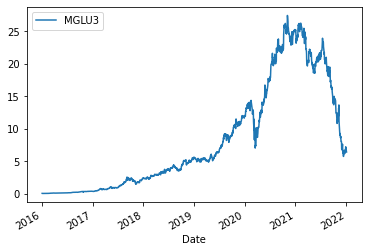

In [7]:
# Gráfico do preço de fechamento ajustado ('Adj Close') de MGLU3
mglu3_df.plot(x='Date', y='Adj Close', label='MGLU3', legend=True)

## Modelagens

Para a modelagem, serão utilizadas como features as colunas 'Open', 'High', 'Low', 'Volume' e o como target a coluna 'Adj Close', que corresponde ao preço de fechamento da ação ajustado.

In [8]:
mglu3_df.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [9]:
df = mglu3_df[['Date', 'Open', 'High', 'Low', 'Volume', 'Adj Close']]
df.head()

,Date,Open,High,Low,Volume,Adj Close
0,2016-01-04,0.066210,0.071484,0.064921,138547200,0.066922
1,2016-01-05,0.071523,0.072578,0.070117,96179200,0.067593
2,2016-01-06,0.070820,0.071484,0.064687,117324800,0.061740
3,2016-01-07,0.062500,0.062500,0.051171,226688000,0.053537
4,2016-01-08,0.058593,0.059570,0.055664,97638400,0.053762


Normalizando os dados com MinMaxScaler:

In [10]:
sc = MinMaxScaler(feature_range= (0,1))
scaled_df = sc.fit_transform(df.drop(columns='Date'))
print(scaled_df.shape)
scaled_df

(1495, 5)


array([[0.000588  , 0.00070775, 0.00058833, 0.38348642, 0.000721  ],
       [0.00077707, 0.00074647, 0.000783  , 0.26621553, 0.00074553],
       [0.00075206, 0.00070775, 0.00057956, 0.32474469, 0.00053154],
       ...,
       [0.26192993, 0.26039994, 0.24805501, 0.40257061, 0.24393907],
       [0.23951026, 0.2437678 , 0.23981245, 0.2622195 , 0.23991779],
       [0.23025769, 0.23633641, 0.23681516, 0.25649657, 0.23297191]])

A seguir, criamos as variáveis para as **features** (X) e **target** (y) e separamos os dados em treino e teste. Para treinar o modelo, os dados são divididos em 70% treino e 30% teste. Note que não usamos o tradicional `train_test_split`, uma vez que os dados precisam ser separados respeitando a sequência temporal.

In [11]:
# criando as features e o target
X = scaled_df[:, :4]
y = scaled_df[:, 4:]

# split the data in 70% training and 30% testing
split = int(0.7 * (len(X)))
X_train = X[:split]
y_train = y[:split]
X_test = X[split:]
y_test = y[split:]

### *Ridge Regression*

Como modelo baseline, foi escolhido uma 'Ridge Regression'. Esse tipo de regressão reduz a complexidade do modelo e previne o *overfitting* que pode resultar de uma regressão linear de dados que sofrem de multicolinearidade, como neste caso.

Primeramente, vamos treinar o modelos com os dados de treino:

In [12]:
model = Ridge()
model.fit(X_train, y_train)

accuracy = model.score(X_test, y_test)
print(f'Ridge Regression score: {accuracy}')

Ridge Regression score: 0.9800640689996484


Vemos que o modelo treinado possui um bom coeficiente de determinação: `R² = 0.9800673067834529`.

#### Resultados

Agora vamos como o modelo se comporta com os dados completos.

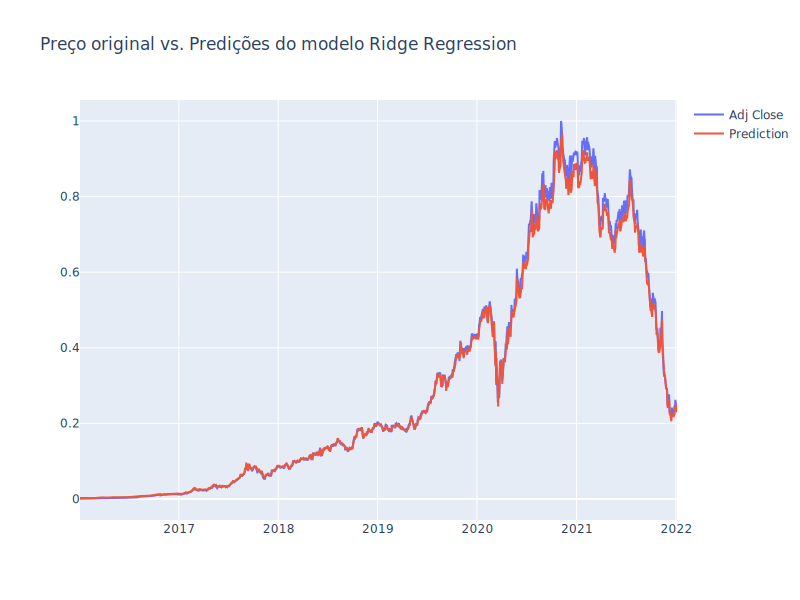

In [13]:
# Previsão de preço
predicted_price = model.predict(X)

# adicionando os valores previstos em uma lista
Predicted = []
for i in predicted_price:
    Predicted.append(i[0])

# adicionando os valores de 'Adj Close' a outra lista
close = []
for i in scaled_df:
    close.append(i[4])

# Criando o dataframe 'df_predicted' 
df_predicted = df[['Date']]

df_predicted['Adj Close'] = close

df_predicted['Prediction'] = Predicted

# traçando os dados
interactive_plot(df_predicted, 'Preço original vs. Predições do modelo Ridge Regression')

Podemos notar que o modelo ajustou bastante bem os dados completos do dataset. 

Abaixo temos os valores das métricas 'mean absolute error' e 'mean squared error' que corroboram a qualidade do ajuste.

In [14]:
MAE = mean_absolute_error(y, predicted_price)
print(f'MAE: {MAE}')
MSE = mean_squared_error(y, predicted_price)
print(f'MSE: {MSE}')

MAE: 0.009366192800565127
MSE: 0.0002603293267325694


Apesar de termos obtido bons resultados, devemos ter em mente que (naturalmente) não teremos previamente informações como os preços de abertura, mínimo, máximo e volumes de transações (que utilizamos como features) para prever o preço futuro da ação no fechamento do dia. Para ter um modelo mais realista, precisamos de novas features que levem outros fatores que podemos estimar, como taxas de juros, inflação e etc. 

#### Sugestões para melhoramento dos modelos

* Criação de novas features
* Otimização de hiperparâmetros

### Prophet (modelo aditivo de regressão)

O Facebook Prophet (fbprophet) é uma biblioteca de previsão implementado em R e Python. É rápido e fornece previsões totalmente automatizadas que podem ser ajustadas manualmente por cientistas e analistas de dados.

A instalação é simples:

`pip install fbprophet`

Para importá-la: 

In [15]:
import plotly.graph_objects as go
from datetime import timedelta

from fbprophet import Prophet
from fbprophet.plot import plot_plotly, plot_components_plotly

Para esta análise, iremos utilizar o mesmo dataset anterior.

In [16]:
today = datetime.today().strftime('2022-01-06')
start_date = '2016-01-01'
mglu3_df = yf.download('MGLU3.SA', start_date, today)

# ajustando 'Date' como coluna / resetando o índice
mglu3_df = mglu3_df.reset_index() 

mglu3_df

[*********************100%***********************]  1 of 1 completed


,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-01-04,0.066210,0.071484,0.064921,0.070117,0.066922,138547200
1,2016-01-05,0.071523,0.072578,0.070117,0.070820,0.067593,96179200
2,2016-01-06,0.070820,0.071484,0.064687,0.064687,0.061740,117324800
3,2016-01-07,0.062500,0.062500,0.051171,0.056093,0.053537,226688000
4,2016-01-08,0.058593,0.059570,0.055664,0.056328,0.053762,97638400
...,...,...,...,...,...,...,...
1490,2021-12-29,6.840000,6.900000,6.700000,6.760000,6.760000,79247400
1491,2021-12-30,6.800000,7.410000,6.770000,7.220000,7.220000,180329400
1492,2022-01-03,7.410000,7.410000,6.670000,6.720000,6.720000,145442000
1493,2022-01-04,6.780000,6.940000,6.450000,6.610000,6.610000,94735500


A biblioteca `Prophet` exige que tenhamos apenas duas colunas em nosso dataframe - 'ds' e 'y', que são as colunas 'Date' e 'Adj Close', respectivamente. A partir disso, podemos ter uma previsão dos valores futuros de 'Adj Close'.

Vamos pegar as colunas necessárias e colocá-las em um novo dataframe. Em seguida, usamos o método `rename` para alterar os nomes das colunas.

In [17]:
df = mglu3_df[['Date', 'Adj Close']]
df = df.rename(columns={"Date": "ds", "Adj Close": "y"})
df.head()

,ds,y
0,2016-01-04,0.066922
1,2016-01-05,0.067593
2,2016-01-06,0.061740
3,2016-01-07,0.053537
4,2016-01-08,0.053762


Vamos visualizar o preço de fechamento 'Adj Close' novamente:

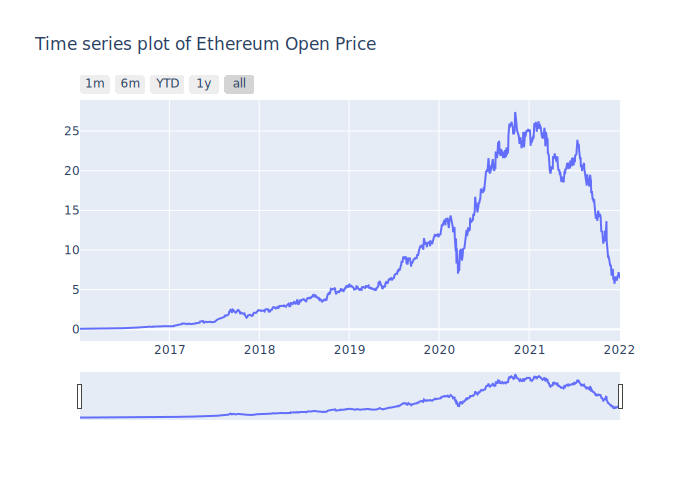

In [18]:
# Gráfico do preço de fechamento ajustado 'Adj Close'

x = df["ds"]
y = df["y"]

fig = go.Figure()

fig.add_trace(go.Scatter(x=x, y=y))

# Set title
fig.update_layout(
    title_text="Time series plot of Ethereum Open Price",
)

fig.update_layout(
    xaxis=dict(
        rangeselector=dict(
            buttons=list(
                [
                    dict(count=1, label="1m", step="month", stepmode="backward"),
                    dict(count=6, label="6m", step="month", stepmode="backward"),
                    dict(count=1, label="YTD", step="year", stepmode="todate"),
                    dict(count=1, label="1y", step="year", stepmode="backward"),
                    dict(step="all"),
                ]
            )
        ),
        rangeslider=dict(visible=True),
        type="date",
    )
)
#fig.show(renderer="svg") # p/ ficar visível no github

#### Modelo

Primeiramente, definimos o modelo e o ajustamos de acordo com o propósito.

Vamos definir, inicialmente, o modelo da forma mais simples possível. 

In [19]:
m = Prophet()

m.fit(df)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -70.0537


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3012.61     0.0928555       1219.88           1           1      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3317.37     0.0375886       865.356           1           1      233   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       3376.09    0.00116788       499.865      0.3793      0.3793      343   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       3424.81     0.0113803       278.415       4.131      0.4131      465   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     453       3429.22   5.99815e-05       79.3807   8.147e-07       0.001      569  LS failed, Hessian reset 
     499       3430.25    0.00227599       184.303           1           1      6

Agora criamos um ano inteiro de dados de data para o modelo fazer previsões com o método `make_future_dataframe`:

In [20]:
future = m.make_future_dataframe(periods = 365)
future.tail()

,ds
1855,2023-01-01
1856,2023-01-02
1857,2023-01-03
1858,2023-01-04
1859,2023-01-05


Podemos executar as previsões através do método `predict` do modelo.

In [21]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1855,2023-01-01,-0.571537,-6.061859,5.102115
1856,2023-01-02,-0.830560,-6.630849,4.863507
1857,2023-01-03,-0.810998,-6.620400,4.640761
1858,2023-01-04,-0.793738,-6.337637,4.612394
1859,2023-01-05,-0.760677,-6.495014,4.543677


O modelo irá retornar um DataFrame com diversas colunas, mas o subconjunto com as colunas mais relevantes para a previsão é:

* ds: datestamp dos valores previstos
* yhat: os valores preditos
* yhat_lower: o limite inferior das previsões
* yhat_upper: o limite superior das previsões

Por curiosidade, podemos obter o predição de preço para o próximo dia dessa maneira:

In [22]:
next_day = (datetime.today() + timedelta(days=1)).strftime('%Y-%m-%d')

forecast[forecast['ds'] == next_day]['yhat'].item()

12.211082500443428

#### Resultados

Por fim, abaixo temos o gráfico contendo os dados originais e as previsões:

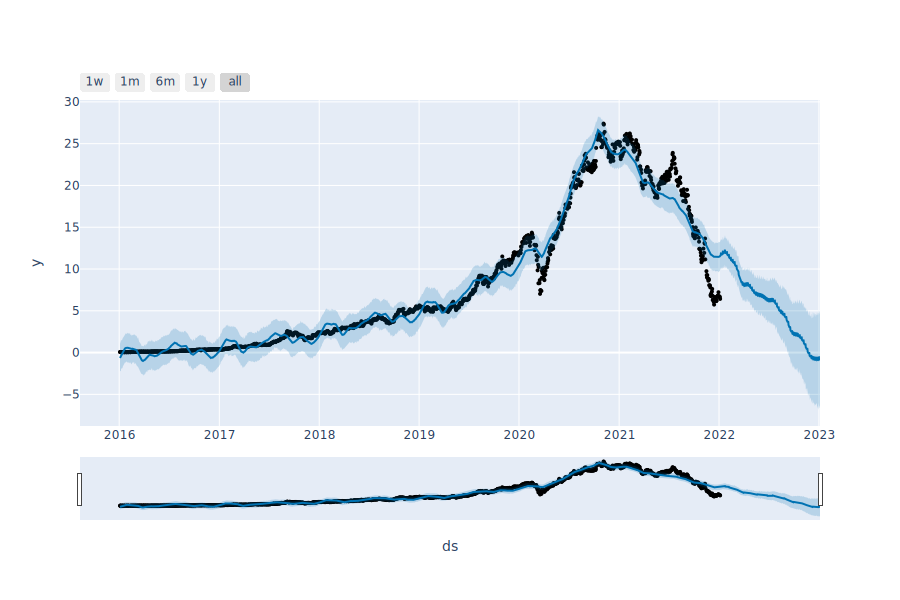

In [23]:
plot_plotly(m, forecast)

O preço das ações da 'MGLU3' teve uma forte queda a partir do segundo semestre de 2021 e o modelo não acompanhou com precisão, o que mostra que para séries temporais altamente voláteis com dependências complexas, como observamos no mercado de ações, a biblioteca Prophet não é adequada.

Além modelo de previsão também inclui a tendência de crescimento (*trend*), a sazonalidade semanal (*weekly*) e componentes sazonais anuais (*yearly*) da curva:

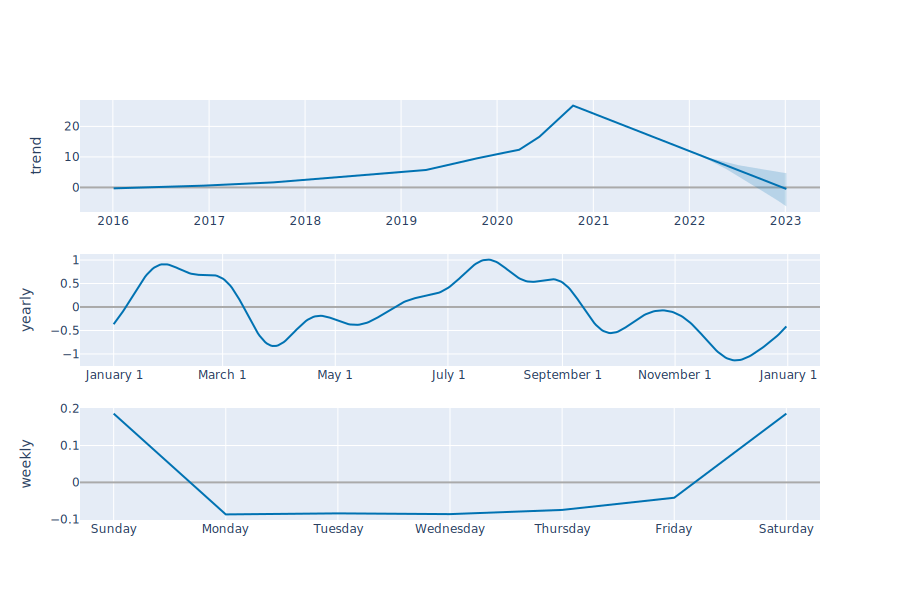

In [24]:
plot_components_plotly(m, forecast)

#### Sugestões para melhoramento dos modelos

* Otimização dos parâmetros do modelo.

## Referências

### Básicas

* [Prevendo valores de ações usando Machine Learning e Deep Learning](https://danilofelipeneto.medium.com/prevendo-valores-de-a%C3%A7%C3%B5es-usando-machine-learning-e-deep-learning-80216e55e582)
* [Ridge and Lasso Regression: L1 and L2 Regularization](https://towardsdatascience.com/ridge-and-lasso-regression-a-complete-guide-with-python-scikit-learn-e20e34bcbf0b)
* [Predicting Stock Prices with Linear Regression in Python](https://www.alpharithms.com/predicting-stock-prices-with-linear-regression-214618/)
* [Stock Price Prediction Using fbprophet](https://jigusc2.medium.com/stock-price-prediction-using-fbprophet-81eeddd4551d)
* [Ethereum Price Prediction with Python](https://medium.com/bitgrit-data-science-publication/ethereum-price-prediction-with-python-3b3805e6e512)
* [Prophet Github page](https://facebook.github.io/prophet/docs/quick_start.html)
* [Tutorial: Time Series Forecasting with Prophet](https://www.kaggle.com/prashant111/tutorial-time-series-forecasting-with-prophet)



### Modelos mais avançados

Abaixo segue uma lista de links com algumas implementações de modelos mais avançados utilizados para previsão, em especial envolvendo redes neurais.

* [Building a Stock Price Predictor Using Python](https://www.section.io/engineering-education/stock-price-prediction-using-python/)
* [BERT for Sentiment Analysis — predicting news for stock market trends](https://wire.insiderfinance.io/bert-for-sentiment-analysis-predicting-news-for-stock-market-trends-9e598a8433bb)
* [Machine Learning for Stock Market Prediction with Step-by-Step Implementation](https://www.analyticsvidhya.com/blog/2021/10/machine-learning-for-stock-market-prediction-with-step-by-step-implementation/)
* [Stock Price Prediction – Machine Learning Project in Python](https://data-flair.training/blogs/stock-price-prediction-machine-learning-project-in-python/)

### Outras

* [Plotly graph shows a blank space on GitHub](https://stackoverflow.com/questions/43562671/plotly-graph-shows-a-blank-space-on-github)